# Comp 551 - Assignment 1

### 1. Model Selection

First, I'll start off by fitting a 20-degree polynomial to Dataset-1

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#Grab training data set
csv_delim = ','
trainingFile = "Dataset1/Dataset_1_train.csv"
validFile = "Dataset1/Dataset_1_valid.csv"
testFile = "Dataset1/Dataset_1_test.csv"

Define functions that will be useful:

Opening files: open_with_numpy
Getting polynomial matrix X: polynomial_matrix, where X is used in:
 
$w^* = (X^TX)^{-1}X^Ty$

polynomial: apply polynomial function to an input array
mean_square_error: calculate MSE

In [2]:
def open_with_numpy(filename):
    data = np.genfromtxt(filename, dtype=np.float64,delimiter=csv_delim)[:,:-1]
    return data


def polynomial_matrix(x, deg):
    matrix = np.fromfunction(lambda i,j: x[i]**j, (len(x), deg+1), dtype=int)
    return matrix


def polynomial(weights):
    poly = lambda x: sum([weights[i]*(x**i) for i in range(0,len(weights))])

    def p(x):
        return np.array([poly(x[i]) for i in range(0,len(x))])
    return p

def mean_square_error(y_actual, y_predict):
    n = len(y_actual)
    s = sum([(y_actual[i] - y_predict[i])**2 for i in range(0,n)])
    return s / n

Fit the 20-deg polynomial:

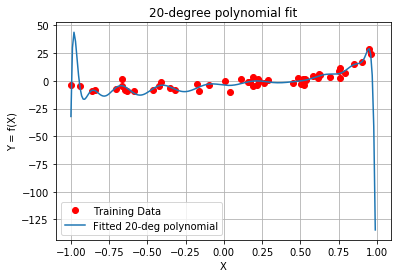

In [3]:
training_data = open_with_numpy(trainingFile);
x = np.asarray(training_data[:,0:1]).flatten()
y = np.asarray(training_data[:,1:2]).flatten()

plt.plot(x, y, 'ro', label="Training Data")
deg20 = 20
oper = polynomial_matrix(x,deg20)

#Moore-Penrose pseudo-inverse of matrix oper * y
weights = np.dot(np.dot(np.linalg.inv((np.dot(oper.T,oper))),oper.T),y)

poly = polynomial(weights);
xs = np.arange(-1.0, 1.0, 0.01)
ys = poly(xs);

plt.plot(xs,ys, label="Fitted 20-deg polynomial")


plt.grid(True)
plt.title("20-degree polynomial fit")
plt.xlabel("X")
plt.ylabel("Y = f(X)")
plt.xlabel("X")

plt.legend()
plt.show()

Now, calculate MSE:

$$\frac{1}{n} \sum_{i=1}^{n} (Y_i - \hat{Y}_i)$$

In [4]:
y_predict = poly(x)
mse_training = mean_square_error(y, y_predict)
print ("Training MSE: " + str(mse_training))

Training MSE: 6.47474731907


In [5]:
validation_data = open_with_numpy(validFile);
x_valid = np.asarray(validation_data[:,0:1]).flatten()
y_valid = np.asarray(validation_data[:,1:2]).flatten()

y_predict_valid = poly(x_valid)
mse_valid = mean_square_error(y_valid, y_predict_valid)
print ("Validation MSE: " + str(mse_valid))

Validation MSE: 1416.72958528


**Comments**: The 20-degree polynomial fit is an example of overfitting. The polynomial hits the training cluster of points really well, but its interpolative and extrapolative abilities are weak. For example, the polynomial seems to diverge significantly from the trend for X > 1.00, and the validation MSE if very high. 

##### L2 Regularization

This introduces $\lambda \in [0,1]$. Thus, the closed form solution changes:

$w^* = (X^TX + \lambda I)^{-1}X^Ty$


In [6]:
plt.clf()

#Use Validation data to do the model selection
oper = polynomial_matrix(x,deg20)

lamb = np.arange(0, 1, 0.01)
mseT = np.zeros(shape=(1,len(lamb))).flatten()
mseV = np.zeros(shape=(1,len(lamb))).flatten()

for l in range(0, len(lamb)):
    lambIdentity = np.dot(lamb[l], np.identity(deg20 + 1))
    w = np.dot(np.dot(np.linalg.inv((np.dot(oper.T, oper)) + lambIdentity), oper.T), y)

    poly = polynomial(w);
    y_p = poly(x)
    mse_t = mean_square_error(y, y_p)
    mseT[l] = mse_t
    
    y_pv = poly(x_valid)
    mse_v = mean_square_error(y_valid, y_pv)
    mseV[l] = mse_v


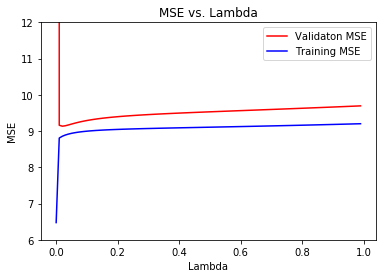

In [7]:
x1 = lamb
x2 = lamb

y1 = mseT
y2 = mseV

# plt.subplot(2,1,1)
# plt.plot(x2, y2, 'r-')
# plt.ylabel('Validation MSE')
# plt.title("Mean Square Error vs. Lambda")

# plt.subplot(2,1,2)
# plt.plot(x1, y1, 'b-')
# plt.xlabel('Lambda')
# plt.ylabel("Training MSE")

plt.plot(x2, y2, 'r-', label="Validaton MSE")
plt.plot(x1, y1, 'b-', label="Training MSE")

axes = plt.gca()
# axes.set_xlim([xmin,xmax])
axes.set_ylim([6,12])
plt.title("MSE vs. Lambda")
plt.xlabel('Lambda')
plt.ylabel("MSE")
plt.legend()
plt.show()

In [8]:
#Find min error:

min = mseT[0] + mseV[0]
index = 0
for l in range(0, len(lamb)):
    newMin = mseT[l] + mseV[l]
    if(newMin < min):
        min = newMin
        index = l

print (lamb[index])

print ("Training MSE: " + str(mseT[index]))
print ("Validation MSE: " + str(mseV[index]))


0.01
Training MSE: 8.80761088044
Validation MSE: 9.16076877961


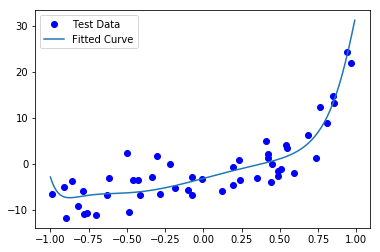

Test MSE: 10.8223496306


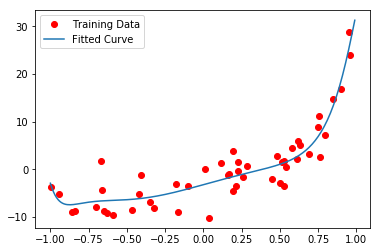

In [9]:
#Test performance:
testing_data = open_with_numpy(testFile);
x_test = np.asarray(testing_data[:,0:1]).flatten()
y_test = np.asarray(testing_data[:,1:2]).flatten()

#Grab the weights using training data
oper = polynomial_matrix(x,deg20)

minLamb = lamb[index]
lambIdentity = np.dot(minLamb, np.identity(deg20 + 1))
w = np.dot(np.dot(np.linalg.inv((np.dot(oper.T, oper)) + lambIdentity), oper.T), y)

poly = polynomial(w);
y_p = poly(xs)

plt.clf()

plt.plot(x_test, y_test, 'bo', label="Test Data")
plt.plot(xs,y_p, label="Fitted Curve")
plt.legend()
plt.show()
plt.clf()

y_actual_test = poly(x_test)
print("Test MSE: " + str(mean_square_error(y_test, y_actual_test)))

plt.plot(x, y, 'ro', label="Training Data")
plt.plot(xs,y_p, label="Fitted Curve")
plt.legend()
plt.show()
plt.clf()


The source polynomial probably has degree 4 or 5. We can infer this from the previous question, by analysing the graph. The graph crosses x-axis once, and it seems that it is trending up again (to cross the x-axis again). Thus, at lease degree 2. The convexity of the graph in the region [-0.75,0.75] isn't smooth enough to suggest degree = 3, (we need more degrees of freedom), thus, I postualte that the source polynomial has degree 4 or 5.

### 2. Gradient Descent for Regression

First, I fit a linear regression model by Stochastic Gradient Descent:

(Alg, N data points, $\alpha$ is the step size)

repeat until convergence:
    $$\text{for i = 1 to N:}\\
        w_0 = w_0 - \alpha (\hat{y}(x^{(i)};w) - y^{(i)})\\
        w_1 = w_1 - \alpha (\hat{y}(x^{(i)};w) - y^{(i)})x^{(i)}$$

In [10]:
csv_delim = ','
trainingFile = "Dataset2/Dataset_2_train.csv"
validFile = "Dataset2/Dataset_2_valid.csv"
testFile = "Dataset2/Dataset_2_test.csv"

In [11]:
#Functions:

def sgd(x, y, x_valid, y_valid, step_size, num):
    coef = [0.0 for i in range(2)]
    n_epoch = range(num)
    err = [0.0 for i in range(num)]
    err_validation = [0.0 for i in range(num)]
    for epoch in n_epoch:
        sum_error_training = 0
        for row in range(len(x)):
            yhat = coef[0] + coef[1] * x[row]
            error = yhat - y[row]
            sum_error_training += error ** 2
            coef[0] = coef[0] - step_size * error
            coef[1] = coef[1] - step_size * error * x[row]
        err[epoch] = sum_error_training / len(x)
        
        y_actual = polynomial(coef)(x_valid)
        err_validation[epoch] = mean_square_error(y_actual,y_valid)
    return (n_epoch, err, err_validation, coef)


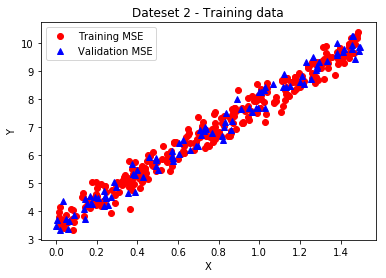

In [12]:
plt.clf()
training_data = open_with_numpy(trainingFile);
x = np.asarray(training_data[:,0:1]).flatten()
y = np.asarray(training_data[:,1:2]).flatten()

validation_data = open_with_numpy(validFile);
x_valid = np.asarray(validation_data[:, 0:1]).flatten()
y_valid = np.asarray(validation_data[:, 1:2]).flatten()

training_data = open_with_numpy(testFile);
x_test = np.asarray(training_data[:, 0:1]).flatten()
y_test = np.asarray(training_data[:, 1:2]).flatten()

plt.plot(x, y, 'ro', label="Training MSE")
plt.plot(x_valid, y_valid, 'b^', label="Validation MSE")
plt.legend()
plt.title("Dateset 2 - Training data")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

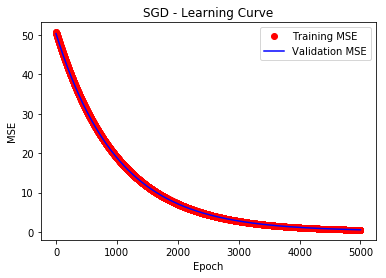

In [13]:
plt.clf()
step = 10 ** -6
r = sgd(x, y, x_valid, y_valid, step, 5000)
plt.plot(r[0], r[1], 'ro',label="Training MSE")
plt.plot(r[0], r[2], 'b-',label="Validation MSE")
plt.legend()
plt.title("SGD - Learning Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()


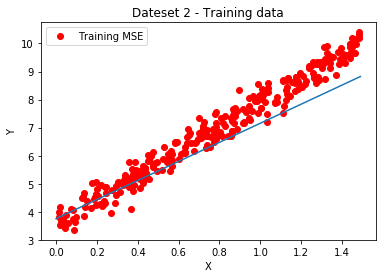

In [14]:
plt.clf()
plt.plot(x, y, 'ro', label="Training MSE")
# plt.plot(x_valid, y_valid, 'b^', label="Validation MSE")

xs = np.arange(0.0, 1.5, 0.01)
ys = polynomial(r[3])(xs)
plt.plot(xs,ys)

plt.legend()
plt.title("Dateset 2 - Training data")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

In [15]:
plt.clf()

minimum = [0,0]
minMSE = -1

for i in range(7,0,-1):
    for j in range(1,10):
        step = j*(10**-i)
        k = sgd(x_valid, y_valid, x_valid, y_valid, step, 5000)
        if(minMSE == -1 or k[1][-1]<minMSE):
            minimum[0] = i
            minimum[1] = j
            minMSE = k[1][-1]
        
print(minimum)
print(minMSE)

[5, 9]
0.0724636433148


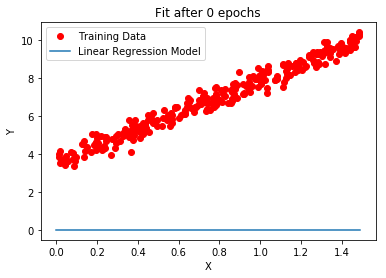

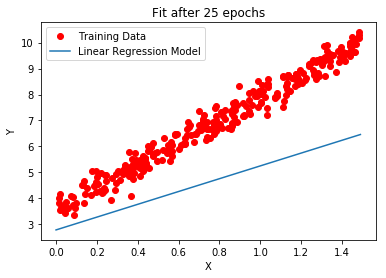

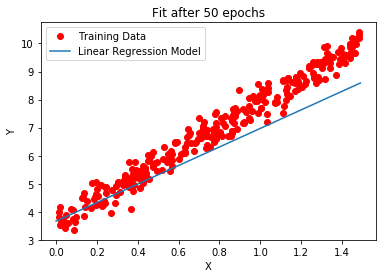

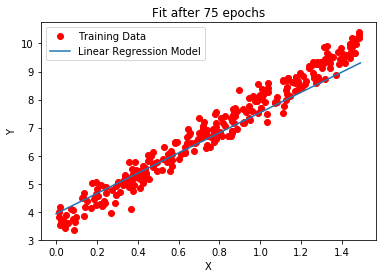

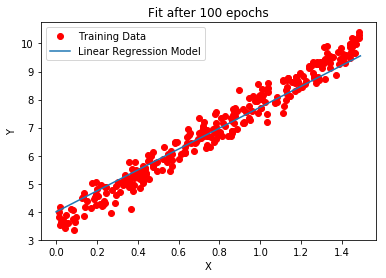

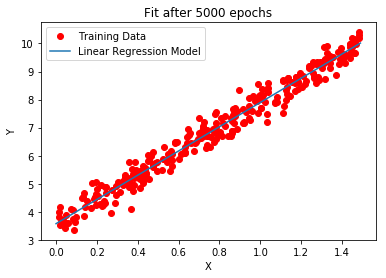

MSE Training: 0.0955080668594
MSE Valid: 0.0740620648431
MSE Test: 0.0692309487224


In [16]:
best_step_size = minimum[1]*(10**-minimum[0])

n_epochs = [0,25,50,75,100,5000]

for i in range(len(n_epochs)):
    
    k = sgd(x, y, x_valid, y_valid, best_step_size, n_epochs[i])
    
    plt.clf()
    plt.plot(x, y, 'ro', label="Training Data")

    xs = np.arange(0.0, 1.5, 0.01)
    ys = polynomial(k[3])(xs)
    plt.plot(xs,ys, label="Linear Regression Model")

    plt.title("Fit after " + str(n_epochs[i]) + " epochs")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.show()

    if(n_epochs[i] == 5000):
        poly = polynomial(k[3])
        
        #training, validation, test
        y_actual_training = poly(x)
        print("MSE Training: " + str(mean_square_error(y_actual_training,y)))
        
        y_actual_valid = poly(x_valid)
        print("MSE Valid: " + str(mean_square_error(y_actual_valid,y_valid)))
        
        y_actual_test = poly(x_test)
        print("MSE Test: " + str(mean_square_error(y_actual_test,y_test)))        

### 3. Real life dataset

Data obtained from http://archive.ics.uci.edu/ml/datasets/Communities+and+Crime

Completed data: CandC-all.csv

I obtained the completed data set by filling in the missing values with the sample mean. Although this choice distorts the variable's distribution and the variable's relationship with other variables, this choice is adequate in that it fills in missing values with a plausible replacement (no extreme outliers). A better method would be to do the average of the neighbourhood of the missing value. This would reduce discontinuity between consecutive values and smooth out the input vector.

##### To obtain the 80-20 data splits: 

In the data set, there are 1994 inputs. So, $$0.20 * 1994 ~= 399$$

Thus, the ~20% split will be inputs:

1. 1-400
2. 401-799
3. 800-1198
4. 1199-1596
5. 1597 - 1994

Further, the first 5 features (state, county, community, communityname, and fold) have been removed, as these are non-predictive features

In [17]:
csv_delim = ','
trainingFiles = ["Dataset3/CandC_train" + str(i) + ".csv" for i in range(1, 6)]
testFiles = ["Dataset3/CandC_test" + str(i) + ".csv" for i in range(1, 6)]

weights = []
mses = []

In [18]:
def oper_matrix(data):
    matrix = data[:,0:-1]
    return matrix


def funct(weights):
    row = lambda x: sum([weights[i]*(x[i]) for i in range(0,len(weights))])

    def p(x):
        return np.array([row(x[i]) for i in range(0,len(x))])
    return p

In [19]:
for i in range(0,len(trainingFiles)):
    test_data = open_with_numpy(testFiles[i])
    training_data = open_with_numpy(trainingFiles[i])

    x_test = oper_matrix(test_data)
    y_test = np.asarray(test_data[:, -1]).flatten()

    y_training = np.asarray(training_data[:, -1]).flatten()
    X = oper_matrix(training_data)

    # Moore-Penrose pseudo-inverse of matrix X * y
    weight = np.dot(np.dot(np.linalg.inv((np.dot(X.T, X))), X.T), y_training)
    f = funct(weight)
    y_predict = f(x_test)
    mse = mean_square_error(y_test,y_predict)

    weights.append(weight);
    mses.append(mse)

# print(mses)
print(sum(mses)/len(mses))

0.189271355327


In [20]:
for j in range(len(weights[0])):
    print("Weight_" + str(j+1) + ":  " + 
          str(weights[0][j]) + " / " +
          str(weights[1][j]) + " / " +
          str(weights[2][j]) + " / " +
          str(weights[3][j]) + " / " +
          str(weights[4][j]))

Weight_1:  0.118843849952 / 0.293917019748 / 0.185176680683 / 0.215300498858 / 0.147323849685
Weight_2:  -0.0500285271063 / 0.0116883794379 / -0.0107665893639 / -0.047876274571 / -0.00128838856439
Weight_3:  0.196148501714 / 0.204652348602 / 0.150965348421 / 0.187289564552 / 0.234196676584
Weight_4:  -0.0292953471256 / -0.00767358135972 / -0.0546308713829 / -0.0988937442097 / -0.0195274384866
Weight_5:  -0.0246627576786 / -0.00225926013603 / -0.00860530977716 / -0.0400553849635 / -0.0241011207079
Weight_6:  0.0928968066645 / 0.0580242459647 / 0.0778128257005 / 0.0950576504154 / 0.00822655059425
Weight_7:  0.125164014049 / 0.122555407973 / 0.0691515577446 / 0.136195895617 / 0.157713191527
Weight_8:  -0.106081350208 / -0.212320895419 / -0.215742045368 / -0.211976473295 / -0.32624195187
Weight_9:  -0.206603637701 / -0.149326950412 / -0.1055349301 / -0.202251839496 / -0.13080469265
Weight_10:  0.0447665240624 / 0.24884115172 / -0.026344869559 / 0.0306809465695 / 0.0528145473034
Weight_11: 

#### Ridge Regression

I'll iterate through $\lambda \in [0,1)$ and find the best $\lambda$

In [21]:
lamb = np.arange(0, 1, 0.01)
index = -1
min = -1
features = 122

best_weights = []

for l in range(len(lamb)):
    mses = []
    weights = []
    lambIdentity = np.dot(lamb[l], np.identity(features))
    for i in range(0, len(trainingFiles)):
        test_data = open_with_numpy(testFiles[i])
        training_data = open_with_numpy(trainingFiles[i])

        x_test = oper_matrix(test_data)
        y_test = np.asarray(test_data[:, -1]).flatten()

        y_training = np.asarray(training_data[:, -1]).flatten()
        X = oper_matrix(training_data)

        # Moore-Penrose pseudo-inverse of matrix X * y
        weight = np.dot(np.dot(np.linalg.inv((np.dot(X.T, X)) + lambIdentity), X.T), y_training)
        f = funct(weight)
        y_predict = f(x_test)
        mse = mean_square_error(y_test, y_predict)
        mses.append(mse)
        weights.append(weight)

    mean_square = sum(mses)/len(mses)
    if(min == -1 or mean_square < min):
        min = mean_square
        index = l
        best_weights = weights

print("Best Lambda: " + str(lamb[index]))

Best Lambda: 0.99


In [22]:
print("MSE of Best Run: " + str(min))

MSE of Best Run: 0.0186942026162


In [23]:
for j in range(len(best_weights[0])):
    print("Weight_" + str(j+1) + ":  " + 
          str(best_weights[0][j]) + " / " +
          str(best_weights[1][j]) + " / " +
          str(best_weights[2][j]) + " / " +
          str(best_weights[3][j]) + " / " +
          str(best_weights[4][j]))

Weight_1:  -0.0458899140208 / 0.028606164232 / -0.020155936163 / -0.0326495239215 / -0.0168857775111
Weight_2:  0.0174859081654 / 0.0335244345999 / 0.0440136838092 / 0.0426713928722 / 0.0197357151036
Weight_3:  0.182918446366 / 0.177596171567 / 0.148573797789 / 0.184364031125 / 0.230104786236
Weight_4:  -0.0173713404814 / -0.0175912563845 / -0.0337382267644 / -0.0611261397402 / -0.0173571143478
Weight_5:  -0.0235971778652 / 0.00440204408309 / -0.0028710554401 / -0.0361703959565 / -0.020493010462
Weight_6:  0.0911174452912 / 0.0709986437293 / 0.0977706434055 / 0.0879585794143 / 0.0234558000937
Weight_7:  0.0459150556973 / 0.0380344777699 / 0.0163753682232 / 0.0483590042661 / 0.0792924593859
Weight_8:  -0.0854944921679 / -0.129991541643 / -0.107592042139 / -0.129131252671 / -0.177614246238
Weight_9:  -0.0553879917344 / -0.0446676298064 / -0.0237258975423 / -0.079939650169 / -0.061493392314
Weight_10:  0.0964230357765 / 0.154673269975 / 0.0456444435414 / 0.0795006665815 / 0.0955753771606


It doesn't appear like any of the weights are small enough to justify feature selection. When running with all 127 features, the non-predictive weights were of the order of $10^{-5}, 10^{-6}, 10^{-7}$, further emphasizing that these features weren't significant in the regression

In [24]:
# Repeat the ridge regression for other values of lambda

def print_weights(weights):
    for j in range(len(weights[0])):
        print("Weight_" + str(j+1) + ":  " + 
              str(weights[0][j]) + " / " +
              str(weights[1][j]) + " / " +
              str(weights[2][j]) + " / " +
              str(weights[3][j]) + " / " +
              str(weights[4][j]))


l = 0.10
features = 122

mses = []
weights = []
lambIdentity = np.dot(l, np.identity(features))
for i in range(0, len(trainingFiles)):
    test_data = open_with_numpy(testFiles[i])
    training_data = open_with_numpy(trainingFiles[i])

    x_test = oper_matrix(test_data)
    y_test = np.asarray(test_data[:, -1]).flatten()

    y_training = np.asarray(training_data[:, -1]).flatten()
    X = oper_matrix(training_data)

    # Moore-Penrose pseudo-inverse of matrix X * y
    weight = np.dot(np.dot(np.linalg.inv((np.dot(X.T, X)) + lambIdentity), X.T), y_training)
    f = funct(weight)
    y_predict = f(x_test)
    mse = mean_square_error(y_test, y_predict)
    mses.append(mse)
    weights.append(weight)

mean_square = sum(mses)/len(mses)

print("Lambda = " + str(l) + ", MSE = " + str(mean_square))
print_weights(weights)


Lambda = 0.1, MSE = 0.0190664075172
Weight_1:  -0.00527719148471 / 0.13747926127 / 0.0400138720932 / 0.0390071608371 / -0.00171422531983
Weight_2:  -0.0272840721824 / 0.0147372295822 / 0.00773511256833 / -0.00987530650632 / 0.0047610652618
Weight_3:  0.200244691832 / 0.198967955076 / 0.157548267127 / 0.191051856183 / 0.248587548609
Weight_4:  -0.0123540631797 / -0.00648661532134 / -0.0386841326061 / -0.0793463875091 / -0.00346043190285
Weight_5:  -0.0204799793059 / 0.00439327451523 / -0.00339934186664 / -0.0348554574131 / -0.0201464122246
Weight_6:  0.104090606443 / 0.0731398573498 / 0.100183453949 / 0.105910402832 / 0.0245024816239
Weight_7:  0.107129046257 / 0.0990224806912 / 0.0539265489374 / 0.117180829954 / 0.150992005624
Weight_8:  -0.119635183463 / -0.212494745589 / -0.204086108944 / -0.206863525992 / -0.302547043371
Weight_9:  -0.152978264853 / -0.106932825267 / -0.0673316160085 / -0.169556632687 / -0.120338280731
Weight_10:  0.072059215398 / 0.218256082864 / -0.00480800568533 

In [25]:
l = 0.50
features = 122

mses = []
weights = []
lambIdentity = np.dot(l, np.identity(features))
for i in range(0, len(trainingFiles)):
    test_data = open_with_numpy(testFiles[i])
    training_data = open_with_numpy(trainingFiles[i])

    x_test = oper_matrix(test_data)
    y_test = np.asarray(test_data[:, -1]).flatten()

    y_training = np.asarray(training_data[:, -1]).flatten()
    X = oper_matrix(training_data)

    # Moore-Penrose pseudo-inverse of matrix X * y
    weight = np.dot(np.dot(np.linalg.inv((np.dot(X.T, X)) + lambIdentity), X.T), y_training)
    f = funct(weight)
    y_predict = f(x_test)
    mse = mean_square_error(y_test, y_predict)
    mses.append(mse)
    weights.append(weight)

mean_square = sum(mses)/len(mses)

print("Lambda = " + str(l) + ", MSE = " + str(mean_square))
print_weights(weights)

Lambda = 0.5, MSE = 0.0187819901964
Weight_1:  -0.0441046234496 / 0.0532596847605 / -0.0152206481041 / -0.0264435635565 / -0.0188785048284
Weight_2:  0.00884451771117 / 0.0308589663001 / 0.0378340217014 / 0.030887236798 / 0.0166715073354
Weight_3:  0.19216518067 / 0.186743545145 / 0.154787295032 / 0.189284364394 / 0.241675563323
Weight_4:  -0.0102495184811 / -0.0102337610527 / -0.0305028261079 / -0.0635276506911 / -0.00688980578467
Weight_5:  -0.0213619514498 / 0.00595205331871 / -0.00183780562787 / -0.034895804607 / -0.0200824124985
Weight_6:  0.100391205514 / 0.0772186766468 / 0.105204198602 / 0.0997608639798 / 0.0261514093556
Weight_7:  0.0666960030049 / 0.0602510237476 / 0.0284911250019 / 0.0728477117525 / 0.111234212383
Weight_8:  -0.107736012532 / -0.167523078603 / -0.145885993671 / -0.164366442418 / -0.22954923273
Weight_9:  -0.0824051031838 / -0.0615830671295 / -0.0344463882824 / -0.109930131272 / -0.0845217247575
Weight_10:  0.0964340249267 / 0.181963407556 / 0.0325288378699 /